In [1]:
from carla.data.causal_model import CausalModel

/home/jacqueline/.local/share/virtualenvs/CARLA-7s4zdYsf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jacqueline/.local/share/virtualenvs/CARLA-7s4zdYsf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jacqueline/.local/share/virtualenvs/CARLA-7s4zdYsf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint

[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


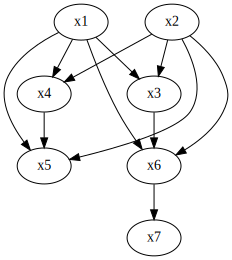

In [2]:
scm_output=CausalModel("credit")
#Visualize the model
scm_output.cgm.draw()

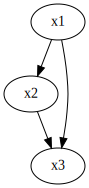

In [3]:
scm_output=CausalModel("sanity-3-lin")
#Visualize the model
scm_output.cgm.draw()

In [4]:
import argparse
import importlib
import Semantic_Meaningfulness_v2
from Semantic_Meaningfulness_v2 import Sematic
importlib.reload(Semantic_Meaningfulness_v2)
import carla.recourse_methods.catalog as recourse_catalog
from carla.data.causal_model import CausalModel
from carla.models.catalog import MLModelCatalog
from carla.models.negative_instances import predict_negative_instances
from carla.data.catalog import CsvCatalog
#from carla.recourse_methods.catalog import recourse_catalog
#from carla.recourse_methods.catalog.roar.model import Roar
from carla.recourse_methods.catalog.causal_recourse import (
    CausalRecourse,
    constraints,
    samplers,
)
#from carla.data.causal_model.synthethic_data import SCMDataset
from carla.recourse_methods import GrowingSpheres
from causal_recourse_do_calculus.model import CausalRecourse_DoCalculus
from carla import Benchmark
import numpy as np 
import pandas as pd
import torch
import random
import os 
import pickle
os.environ["CUDA_VISIBLE_DEVICES"]=""
import warnings

In [5]:
def MLP(dataset, name):
    '''
    Load and return MLP. 
    Attributes: 
        dataset carla.XXX : data to train on 
        name str: dataset name 
    Returns: 
        carla.XXX
    '''
    
    training_params = {"lr": 0.002, "epochs": 10, "batch_size": 1024, "hidden_size": [18, 9, 3],' num_of_classes':2}
 #{"lr": 0.01, "epochs": 10, "batch_size": 32, "hidden_size": [100, 50, 10]}

    ml_model = MLModelCatalog(
    dataset, model_type="ann", load_online=False, backend="pytorch"
    )
    if os.path.isfile(f'./Results/Model/MLP_{name}.pth'):
        model=torch.load(f'./Results/Model/MLP_{name}.pth')
        ml_model._model=model
    else:
        ml_model.train(
        learning_rate=training_params["lr"],
        epochs=training_params["epochs"],
        batch_size=training_params["batch_size"],
        hidden_size=training_params["hidden_size"],
        force_train=True
        )

        torch.save(ml_model.raw_model,f'./Results/Model/MLP_{name}.pth')
    return ml_model
def data(name, not_causal=True):
    '''
    Load and return Toy Dataset.
    Attribute: 
        name str: Name of the Dataset. 

    Returns: 
        (dataset, scm, scm_output): returns Dataset, Structural Causal Model and Structural Causal Model with output Layer.
    '''
    scm = CausalModel(f"{name}")
    scm_output = CausalModel(f"{name}-output")
    if not os.path.isdir(f'./data/{name}'):
        os.mkdir(f'./data/{name}')
    if not os.path.isfile(f'./data/{name}/{name}.csv'):
        print('TRUE 1 ')
        # generate data
        dataset = scm.generate_dataset(10000, False)
        print(f'./data/{name}/{name}.csv')
        dataset.df.to_csv(f'./data/{name}/{name}.csv', index=False)
        #pickle.dump(dataset.train_raw, open(f'./data/{name}/{name}_train_raw.pkl','wb'))
        #pickle.dump(dataset.test_raw, open(f'./data/{name}/{name}_test_raw.pkl','wb'))
        #pickle.dump(dataset.raw, open(f'./data/{name}/{name}_raw.pkl','wb'))
        #pickle.dump(dataset.noise, open(f'./data/{name}/{name}_noise.pkl','wb'))
        if not_causal:
            dataset = pd.read_csv(f'./data/{name}/{name}.csv')
            #TODO Better way for defining continous varaibles ?
            continuous_wachter = dataset.drop(columns=['label']).columns
            dataset = CsvCatalog(file_path=f'./data/{name}/{name}.csv',
                     continuous=continuous_wachter,
                     categorical=[],
                     immutables=[],
                     target='label',
                     )
    else: 
        if not_causal:
            dataset = pd.read_csv(f'./data/{name}/{name}.csv')
            #TODO Better way for defining continous varaibles ?
            continuous_wachter = dataset.drop(columns=['label']).columns
            dataset = CsvCatalog(file_path=f'./data/{name}/{name}.csv',
                     continuous=continuous_wachter,
                     categorical=[],
                     immutables=[],
                     target='label',
                     )
        else: 

            dataset = pd.read_csv(f'./data/{name}/{name}.csv')
            continuous_wachter = dataset.drop(columns=['label']).columns
            #TODO Does Scaling Method Idendity make sense ? 
            dataset = CsvCatalog(file_path=f'./data/{name}/{name}.csv',
                     continuous=continuous_wachter,
                     categorical=[],
                     immutables=[],
                     target='label',
                     )
    
    return dataset, scm , scm_output

In [6]:
dataset, scm , scm_output=data('economic')
print(len(dataset._df_test[dataset._df_test['label']==1.0]))
print(len(dataset._df_test[dataset._df_test['label']==0.0]))
print(len(dataset._df_train[dataset._df_train['label']==1.0]))
print(len(dataset._df_train[dataset._df_train['label']==0.0]))
MLP(dataset, 'economic')

Noise Distribution Finished
1036
1464
3308
4192


In [7]:
import sklearn
name='MLP_economic.pth'
model=torch.load(f'./Results/Model/{name}')
name=name.split('_')[1]
name=name.replace('.pth','')
dataset = pd.read_csv(f'./data/{name}/{name}.csv')
continuous_wachter = dataset.drop(columns=['label']).columns
dataset = CsvCatalog(file_path=f'./data/{name}/{name}.csv',
                     continuous=continuous_wachter,
                     categorical=[],
                     immutables=[],
                     target='label',
                     scaling_method='MinMax')
dataset=dataset._df_test
data_x, data_y=dataset.drop(columns=['label']), dataset['label']
data_pred= model.predict(data_x)

print(data_pred.shape)
print(data_y.shape)
if len(data_pred.shape)>1:
    data_pred= np.argmax(data_pred, axis=1)
print(sklearn.metrics.accuracy_score(data_y,data_pred))
print(sklearn.metrics.precision_score(data_y,data_pred))
print(sklearn.metrics.recall_score(data_y,data_pred))


(2500, 2)
(2500,)
0.8432
0.7979363714531384
0.8552995391705069


/home/jacqueline/.local/share/virtualenvs/CARLA-7s4zdYsf/lib/python3.7/site-packages/carla/models/catalog/ANN_TORCH/model_ann.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)
